In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn

from torchvision import transforms
from torchvision.utils import save_image


In [2]:
batch_size = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

mnist = torchvision.datasets.MNIST(root='datasets/', train=True, transform=transform, download=True)

data_loader = torch.utils.data.DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True)


In [3]:
data_iter = iter(data_loader)
images, labels = next(data_iter)

img = torchvision.utils.make_grid(images)

img = img.detach().numpy()
img = img.clip(0,1)


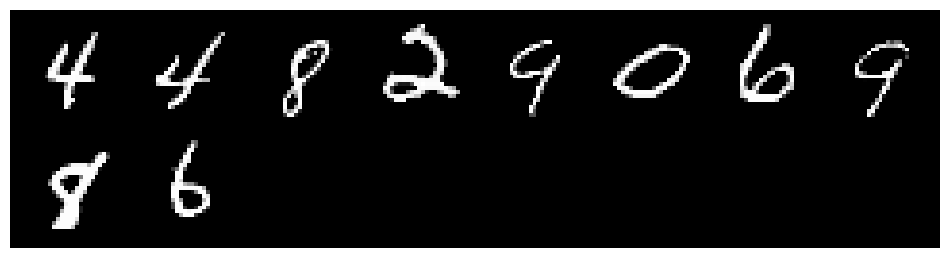

In [4]:
plt.figure(figsize = (12,10))
plt.imshow(np.transpose(img, (1,2,0)))
plt.axis('off')
plt.show()


In [5]:
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 25


In [6]:
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Dropout(0.5),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Dropout(0.5),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())


In [7]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())


In [8]:
D = D.to(device)
G = G.to(device)


In [9]:
bce_loss = nn.BCELoss()

d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

total_step = len(data_loader)


In [10]:
for epoch in range(num_epochs):

    for i, (images, _) in enumerate(data_loader):

        images = images.reshape(batch_size, -1).to(device)

        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Training the Discriminator

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))

        outputs = D(images)

        # Second term of the loss is always zero since real_labels == 1
        # This is what causes it to minimize the loss for real images
        d_loss_real = bce_loss(outputs, real_labels)
        real_score = outputs

        # Compute BCELoss using fake images

        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)

        outputs = D(fake_images)

        # First term of the loss is always zero since fake_labels == 0
        # This is what causes it to maximize the loss for fake images
        d_loss_fake = bce_loss(outputs, fake_labels)
        fake_score = outputs

        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake

        d_optimizer.zero_grad()
        g_optimizer.zero_grad()

        d_loss.backward()
        d_optimizer.step()

        # Training the Generator

        # Compute loss with fake images

        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)

        # train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))

        g_loss = bce_loss(outputs, real_labels)

        # Backprop and optimize
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()

        g_loss.backward()
        g_optimizer.step()

        if (i+1) % 200 == 0:
                        print(f"Epoch [{epoch}/{num_epochs}], Step [{i+1}/{total_step}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}")


    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)


Epoch [0/25], Step [200/6000], d_loss: 0.1219, g_loss: 3.7298, D(x): 0.98, D(G(z)): 0.09
Epoch [0/25], Step [400/6000], d_loss: 0.1738, g_loss: 2.4220, D(x): 0.95, D(G(z)): 0.11
Epoch [0/25], Step [600/6000], d_loss: 0.3495, g_loss: 4.4623, D(x): 0.85, D(G(z)): 0.15
Epoch [0/25], Step [800/6000], d_loss: 0.9387, g_loss: 1.5158, D(x): 0.72, D(G(z)): 0.37
Epoch [0/25], Step [1000/6000], d_loss: 1.6192, g_loss: 0.8737, D(x): 0.55, D(G(z)): 0.54
Epoch [0/25], Step [1200/6000], d_loss: 1.1687, g_loss: 1.4436, D(x): 0.60, D(G(z)): 0.43
Epoch [0/25], Step [1400/6000], d_loss: 1.3127, g_loss: 0.8856, D(x): 0.56, D(G(z)): 0.48
Epoch [0/25], Step [1600/6000], d_loss: 0.6993, g_loss: 0.8188, D(x): 0.79, D(G(z)): 0.32
Epoch [0/25], Step [1800/6000], d_loss: 0.8843, g_loss: 2.3432, D(x): 0.63, D(G(z)): 0.24
Epoch [0/25], Step [2000/6000], d_loss: 0.3458, g_loss: 2.5437, D(x): 0.88, D(G(z)): 0.17
Epoch [0/25], Step [2200/6000], d_loss: 0.3543, g_loss: 2.3203, D(x): 0.87, D(G(z)): 0.13
Epoch [0/25], 

In [11]:
img = torchvision.utils.make_grid(fake_images)

img = img.detach().cpu().numpy()
img = img.clip(0,1)


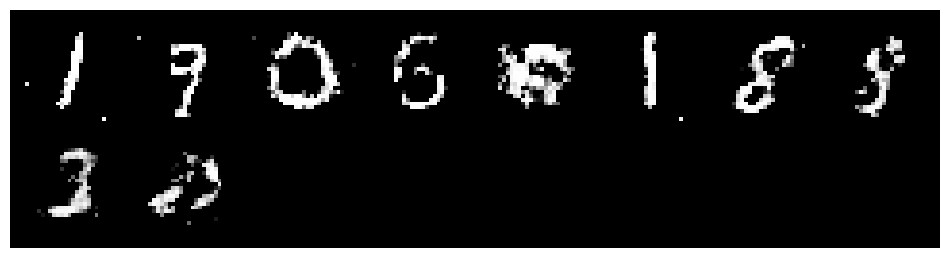

In [12]:
plt.figure(figsize = (12, 10))
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.axis('off')
plt.show()
